In [95]:
import matplotlib.pyplot as plt

In [108]:
from collections import defaultdict

def parse_gamma_lines(lines):
    p = re.compile(r'Current gamma=(?P<gamma>0.[0-9]*) (?P<time>\d+)')
    res = defaultdict(list)
    for aline in lines:
        match=p.match(aline)
        if match:
            d = match.groupdict()
            gamma = float(d['gamma'])
            ts = int(d['time'])

            res[gamma].append(ts)
            
    return res
    
    
def parse_stream_step1(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    return {gamma: (t[1]-t[0]) for gamma, t in parse_gamma_lines(lines).items()}

    
def parse_stream_step3(fname):
    with open(fname, 'r') as f:
        lines = f.readlines()
    # here we have 3 values (two phases) (merging and converting)
    merging= {gamma: (t[1]-t[0]) for gamma, t in parse_gamma_lines(lines).items()}
    converting = {gamma: (t[2]-t[1]) for gamma, t in parse_gamma_lines(lines).items()}
    return merging, converting


def totals(dicts):
    res = defaultdict(lambda: 0)
    for g in dicts[0].keys():
        for d in dicts:
            res[g]+=d[g]
    return res

In [115]:
stream_parts = [6, 10, 16, 32]

In [120]:
stream_results = {}
for part in stream_parts:
    p1 =  parse_stream_step1(fname=f"../res/newestcluster/times/stream/part{part}/s1.out")
    p2 =  parse_stream_step1(fname=f"../res/newestcluster/times/stream/part{part}/s2.out")
    p3, p4 =  parse_stream_step3(fname=f"../res/newestcluster/times/stream/part{part}/s3.out")
    total = totals([p1, p2, p3, p4])
    
    stream_results[part] = [p1, p2, p3, p4, total]
    

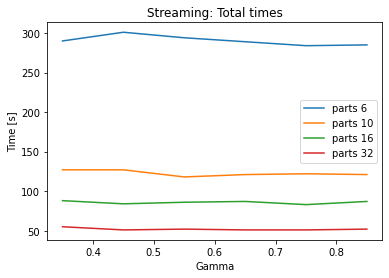

In [123]:
plt.title('Streaming: Total times')

for part, [p1, p2, p3, p4, total] in stream_results.items():
        plt.plot(total.keys(), total.values(), label=f"parts {part}")
        
plt.legend()
plt.xlabel('Gamma')
plt.ylabel('Time [s]');

In [143]:
def plot_part(part):
    [net_calc, net_update, merge, convert, total] = part
    
    plt.plot(net_calc.keys(), net_calc.values(), label='Network cration')
    plt.plot(net_update.keys(), net_update.values(), label='Network update')
    plt.plot(merge.keys(), merge.values(), label='Merging')
    plt.plot(convert.keys(), convert.values(), label='Converting')
    
    plt.plot(total.keys(), total.values(), label='Total')
    
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');

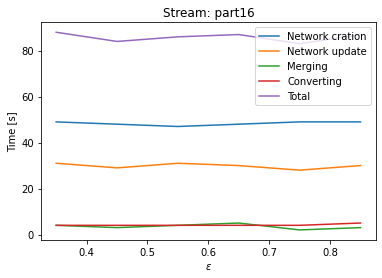

In [144]:
plt.title('Stream: part16')
plot_part(stream_results[16])

## Merge

In [133]:
! ls ../res/newestcluster/times/merge/

part10 part16 part32 part6


In [137]:
merge_parts = [6, 10, 16, 32]

In [158]:
merge_results = {}
for part in merge_parts:
    net_calc, convert =  parse_stream_step3(fname=f"../res/newestcluster/times/merge/part{part}/s1.out")
    merge =  parse_stream_step1(fname=f"../res/newestcluster/times/merge/part{part}/s2.out")

    total = totals([net_calc, convert, merge])
    
    merge_results[part] = [net_calc, convert, merge, total]

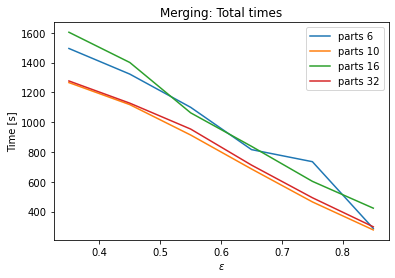

In [159]:
plt.title('Merging: Total times')

for part, [net_calc, convert, merge, total] in merge_results.items():
        plt.plot(total.keys(), total.values(), label=f"parts {part}")
        
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Time [s]');

In [160]:
def plot_merge_part(part):
    [net_calc, convert, merge, total] = part
    
    plt.plot(net_calc.keys(), net_calc.values(), label='Network cration')
    plt.plot(convert.keys(), convert.values(), label='Converting')
    plt.plot(merge.keys(), merge.values(), label='Merge')
    
    
    plt.plot(total.keys(), total.values(), label='Total')
    
    plt.legend()
    plt.xlabel('$\epsilon$')
    plt.ylabel('Time [s]');

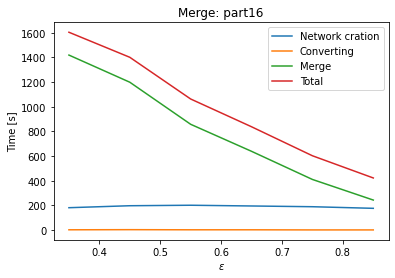

In [161]:
plt.title('Merge: part16')
plot_merge_part(merge_results[16])

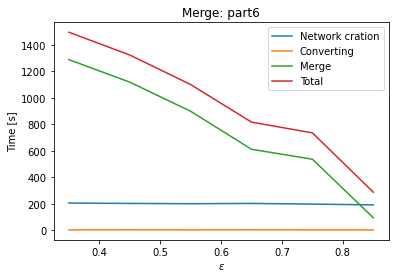

In [162]:
plt.title('Merge: part6')
plot_merge_part(merge_results[6])